In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
app_df=pd.read_csv('/content/applicant.csv')
loan_df=pd.read_csv('/content/loan.csv')


## EDA

# Dealing with missing values(EDA)

In [102]:
app_df
## checking for missing values
app_df.isna().sum()

applicant_id                                                  0
Primary_applicant_age_in_years                                0
Gender                                                        0
Marital_status                                                0
Number_of_dependents                                          0
Housing                                                       0
Years_at_current_residence                                    0
Employment_status                                             0
Has_been_employed_for_at_least                               62
Has_been_employed_for_at_most                               253
Telephone                                                   596
Foreign_worker                                                0
Savings_account_balance                                     183
Balance_in_existing_bank_account_(lower_limit_of_bucket)    668
Balance_in_existing_bank_account_(upper_limit_of_bucket)    457
dtype: int64

In [103]:
## visualizing missing values column wise
#missing values % in each column
def missing(df):
    dict_missing_perc={}
    dict_missing_count={}
    for column in df.columns:
        dict_missing_perc[column]=round((df[column].isna().sum()*100/df.shape[0]),2)
        dict_missing_count[column]=df[column].isna().sum()
    sorted_perc=sorted(list(dict_missing_perc.values()),reverse=True)
    sorted_count=sorted(list(dict_missing_count.values()),reverse=True)
   
  
    data_frame=pd.DataFrame({"Column_name":list(dict_missing_perc.keys()),
                             '% missing values':list(dict_missing_perc.values()),
                             'missing_value_count':list(dict_missing_count.values())})
    #data_frame.index=list(dict_missing_perc.keys())
    data_frame.sort_values(by='% missing values',axis=0,ascending=False,inplace=True)
    data_frame=data_frame.style.background_gradient(cmap='rainbow_r')
    
    return data_frame

In [104]:
app_df['Employment_status'].value_counts()

skilled employee / official                                         630
unskilled - resident                                                200
management / self-employed / highly qualified employee / officer    148
unemployed / unskilled - non-resident                                22
Name: Employment_status, dtype: int64

In [105]:
missing(app_df)

In [106]:
## replacing missing values in 'Has_been_employed_for_at_most','Has_been_employed_for_at_lease' column by mode of column but
# these values can also be replaced by  using Employment_status, Primary_applicant_age_in_years 
app_df['Has_been_employed_for_at_most']=app_df['Has_been_employed_for_at_most'].fillna('4 years')
app_df['Has_been_employed_for_at_least']=app_df['Has_been_employed_for_at_least'].fillna('1 year')

In [107]:
# replacing missing values in 'Savings_account_balance' by  a new category 'very low'
app_df['Savings_account_balance']=app_df['Savings_account_balance'].fillna('very low')

In [108]:
## as most of values in 'Balance_in_existing_bank_account_(lower_limit_of_bucket)' and 'Balance_in_existing_bank_account_(upper_limit_of_bucket)'
# columns are missing so dropping them, but those can be replaced with appropriate values by taking help of other features
app_df=app_df.drop(columns=['Balance_in_existing_bank_account_(lower_limit_of_bucket)','Balance_in_existing_bank_account_(upper_limit_of_bucket)'])

In [109]:
## as Telephone columns contains info about whether person has telephone connection or not
## so replacing missing values with no .i.e. doesn't have connection
app_df['Telephone']=app_df['Telephone'].fillna('No')


In [110]:
## missing values in loan
missing(loan_df)

In [111]:
## even though 'Other_EMI_plans' column has more than 80% missing values I am replacing
# those with a new category 'No emi plans', as it is obvious we fill 'NA' when we don't have other emi plans
## same for 'Property' column
loan_df['Other_EMI_plans']=loan_df['Other_EMI_plans'].fillna('No Emi Plans')
loan_df['Property']=loan_df['Property'].fillna('No property')
## for 'Purpose' I am replacing with mode, but a better way will be to take help of ohter 
#features(like Principal_loan_amount)
loan_df['Purpose']=loan_df['Purpose'].fillna('electronic equipment')

In [112]:
df=pd.merge(app_df,loan_df,on=['applicant_id'],how='inner')
missing(df)

In [113]:
## as application_id,loan_application_id is unique for each applicant so dropping them
df=df.drop(['applicant_id','loan_application_id'],axis=1)

In [114]:
df_org=df.copy()

## some of the numerical features even they contain numerical values can be represented in better way if they are considered as categorical

In [115]:
##  only two features'Primary_applicant_age_in_years' and ''Principal_loan_amount'
# are continuous in nature and remaining numerical variables are not continuous in nature(they are ordinal)

# feature engineering(creating derived features)

more complex features can be created by using information from multiple columns
 for example Marital status and Years_at_current_residence, we can create a feature which will give us an idea of stability/reliablity of applicant

 'Employment_status' and 'Loan_history' can be used to create new feature which will represent chances of paying back the loan.
 In same way we can use other combination of features

In [116]:
## creating new features
# whether applicant has something which can be used as mortgage
df['mortgage']=df_org['Property'].apply(lambda x: 0 if x==0 else 1)

#based on Months_loan_taken_for I am creating new feature 
# if loan taken for less than 12 months-short term, between 12 to 36 months medium term, more than 36months -long term
# and converting those to numerical values
df['term_of_loan']=df['Months_loan_taken_for'].apply(lambda x: 10 if x<12 else 5 if x>=12 and x<=36 else 0 )

# creating new feature type of loan based on Purpose
# business_loan, necessity_loan, luxury
def convert(val):
  if val=='used vehicle' or val=='repair costs' or val=='education' or val=='career development':
    return 'necessity'
  elif val=='business' or val=='FF&E':
    return 'business'
  else:
    return 'luxury'

df['type_of_loan']=df['Purpose'].apply( lambda x:convert(x))

# creating new feature based on principal amount
# if principal amount is less than 30 lacs then low_value(0), if between 30 to 70 lacs medium_value(5), more than 70 lacs
# high value(10)
df['loan_value']=df['Principal_loan_amount'].apply(lambda x: 10 if x>7000000 else (5 if x>=3000000 and x<=7000000  else 0))

# creating new feature 'risk_taking_tendency' based on age of applicants(youth maximum, adults medium, senior citizens low)
# if age less than 30 then youth, if age in between 30 to 55 youth, if age more than 55 senior
# max_risk=10, medium=5 , low_risk_tendency=0
df['risk_taking_tendency']=df['Primary_applicant_age_in_years'].apply(lambda x: 10 if x<25 else (5 if x>=25 and x<55 else 0))

 Dealing with skewness of features

In [117]:
## features are highly skewed, so using some transformation to reduce skewness

## I tried sqrt,log,boxcox transformation and boxcox is giving better results
from scipy.stats import boxcox
df['Primary_applicant_age_in_years'],_=boxcox(df['Primary_applicant_age_in_years'])
df['Principal_loan_amount'],_=boxcox(df['Principal_loan_amount'])


In [118]:
 
## from boxplot(After applying boxcox transformation) it is evident there are only 2 outliers in 'Principal_loan_amount' feature
## and Primary_applicant_age_in_years doesn't have outliers

In [119]:
from sklearn.preprocessing import LabelEncoder

## Converting categorical variables to numerical values, I am using OneHot,Label Encoding as well as manually doing some of the encoding as per understanding of dataset

In [120]:
# manual encoding and label encoding is used for features which are ordinal in nature 
#i.e. there is some kind of order in values of features
df[ 'Loan_history']=df[ 'Loan_history'].map({'existing loans paid back duly till now':10,
                                             'no loans taken/all loans paid back duly':8,
                                             'all loans at this bank paid back duly':6,
                                             'critical/pending loans at other banks':3,
                                             'delay in paying off loans in the past':1})

df['Housing']=df['Housing'].map({'own':10,'rent':6,'for free':2})

df['Employment_status']=df['Employment_status'].map({'management / self-employed / highly qualified employee / officer':10,
                                                     'skilled employee / official':7,
                                                     'unskilled - resident':4,
                                                     'unemployed / unskilled - non-resident':2})

le=LabelEncoder()
df['Has_been_employed_for_at_least']=le.fit_transform(df['Has_been_employed_for_at_least'].values)
le=LabelEncoder()
df['Has_been_employed_for_at_most']=le.fit_transform(df['Has_been_employed_for_at_most'].values)

df[ 'Savings_account_balance']=df[ 'Savings_account_balance'].map({'Very high':10,'High':7,
                                                                   'Medium':5,'Low':3,'very low':1})

df[ 'Property']=df[ 'Property'].map({'real estate':10,'building society savings agreement/life insurance':7,
                                     'car or other':4,'No property':1})

# Feature Selection
 for numerical features-->
 as our target variable is categorical, so we will use ANOVA to find the feature importance of numerical variable i.e. how effective a numerical feature is  in predicting the target variable

for categorical features-->
as our target variable is categorical, so we will use chi_square test to find the feature importance of categorical variable i.e. how effective a categorical feature is  in predicting the target variable

Higher the ANOVA,chi_square value for a feature means that feature is more important.

In [121]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,chi2
from matplotlib import pyplot

In [122]:
l=[] ## list of numerical features
for col in df.columns:
  if df[col].dtype!='object' and col!='high_risk_applicant':
    l.append(col)

Feature Primary_applicant_age_in_years: 11.933513
Feature Number_of_dependents: 0.009071
Feature Housing: 16.567939
Feature Years_at_current_residence: 0.008787
Feature Employment_status: 1.170027
Feature Has_been_employed_for_at_least: 13.439174
Feature Has_been_employed_for_at_most: 13.576144
Feature Foreign_worker: 6.769174
Feature Savings_account_balance: 1.624480
Feature Months_loan_taken_for: 48.333790
Feature Principal_loan_amount: 11.367202
Feature EMI_rate_in_percentage_of_disposable_income: 5.259417
Feature Property: 20.718883
Feature Has_coapplicant: 3.942491
Feature Has_guarantor: 3.032447
Feature Number_of_existing_loans_at_this_bank: 2.091652
Feature Loan_history: 11.154407
Feature mortgage: nan
Feature term_of_loan: 40.320640
Feature loan_value: 15.559879
Feature risk_taking_tendency: 6.949771


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


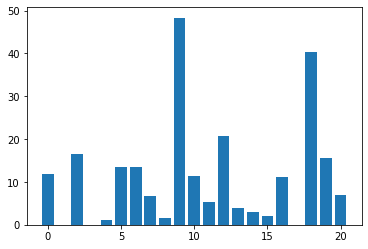

In [123]:
def select_features(X_train, y_train):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	
	
	return X_train_fs, fs
 
# split into train and test sets
X_train,y_train=df[l].values,df['high_risk_applicant'].values
cols=l
# feature selection
X_train_fs, fs = select_features(X_train, y_train)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (cols[i], fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [124]:
df.columns

Index(['Primary_applicant_age_in_years', 'Gender', 'Marital_status',
       'Number_of_dependents', 'Housing', 'Years_at_current_residence',
       'Employment_status', 'Has_been_employed_for_at_least',
       'Has_been_employed_for_at_most', 'Telephone', 'Foreign_worker',
       'Savings_account_balance', 'Months_loan_taken_for', 'Purpose',
       'Principal_loan_amount', 'EMI_rate_in_percentage_of_disposable_income',
       'Property', 'Has_coapplicant', 'Has_guarantor', 'Other_EMI_plans',
       'Number_of_existing_loans_at_this_bank', 'Loan_history',
       'high_risk_applicant', 'mortgage', 'term_of_loan', 'type_of_loan',
       'loan_value', 'risk_taking_tendency'],
      dtype='object')

In [125]:
## I am considering both categorical and ordinal(numerical features i.e. which contains numerical values
#but are ordinal in nature) so dropping 'Primary_applicant_age_in_years' and Principal_loan_amount' because
# therse are continuous 
l.remove('Principal_loan_amount')
l.remove('Primary_applicant_age_in_years')

for col in df.columns:
  if df[col].dtype=='object':
    l.append(col)

#creating temperory dataframe 

df_temp=df[l]
for col in df_temp.columns:
  if type(df_temp[col][0])==str:
    df_temp[col]=LabelEncoder().fit_transform(df_temp[col].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Feature Number_of_dependents: 0.001031
Feature Housing: 14.118312
Feature Years_at_current_residence: 0.003766
Feature Employment_status: 0.627972
Feature Has_been_employed_for_at_least: 9.691676
Feature Has_been_employed_for_at_most: 4.138547
Feature Foreign_worker: 0.249271
Feature Savings_account_balance: 2.048341
Feature Months_loan_taken_for: 321.030795
Feature EMI_rate_in_percentage_of_disposable_income: 2.204619
Feature Property: 34.033750
Feature Has_coapplicant: 3.773519
Feature Has_guarantor: 2.871795
Feature Number_of_existing_loans_at_this_bank: 0.495516
Feature Loan_history: 20.401859
Feature mortgage: 0.000000
Feature term_of_loan: 45.894001
Feature loan_value: 72.766323
Feature risk_taking_tendency: 7.209613
Feature Gender: 1.766736
Feature Marital_status: 4.390752
Feature Telephone: 0.792551
Feature Purpose: 4.212020
Feature Other_EMI_plans: 12.875741
Feature type_of_loan: 1.312099


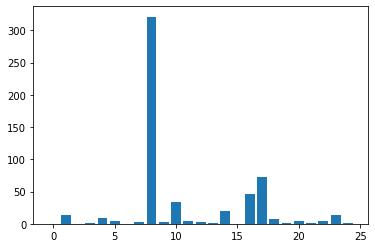

In [126]:
## for categorical variables
# feature selection
def select_features(X_train, y_train):
	# configure to select all features
	fs = SelectKBest(score_func=chi2, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	
	
	return X_train_fs, fs
 
# split into train and test sets
X_train,y_train=df_temp.values,df['high_risk_applicant'].values


cols=l
# feature selection
X_train_fs, fs = select_features(X_train, y_train)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (cols[i], fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

From Anova and chisquare analysis it is evident that
'Number_of_dependents','Years_at_current_residence','Number_of_existing_loans_at_this_bank', 

'Gender','Telephone','Foreign_worker','Savings_account_balance'. 
are not much significant  in predicting the target so these can be dropped if needed, but I am not dropping as dataset already has less features

From Anova and Chisquare analysis it is evident that following features are most important in predicting the target.
'loan_value','risk_taking_tendency','term_of_loan','Loan_history','Property','Has_been_employed_for_at_least',  'Has_been_employed_for_at_most', 'Housing', 'Primary_applicant_age_in_years', 'Foreign_worker', 'EMI_rate_in_percentage_of_disposable_income', 'Months_loan_taken_for'. 

In [127]:
df1=df.copy()
df2=df1.copy()

Categorical features which are not ordinal in nature using OHE techinique to convert them to numerical form

In [128]:
df=pd.get_dummies(df)

## creating training and validation set

Here instead of using simple train_test_split i.e deviding data in two parts using(80%,20% or 70% ,30%), I am using 5fold cross validation to know the real performance of model, as some times simple train_test_split doesn't paint correct picture about performance of model

In [129]:
from sklearn.model_selection import StratifiedKFold
# as dataset is imbalanced that's the reason for using StratifiedKFold
df['fold']=0
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for f,(t,v) in enumerate(skf.split(df.values,y=df['high_risk_applicant'].values)):
  df.loc[v,'fold']=f
df['fold'].value_counts()

2    200
3    200
4    200
0    200
1    200
Name: fold, dtype: int64

In [130]:
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
## as dataset contains negligible outliers so I am using StandardScaler for standardizing features
## if dataset would have contained more outliers then RobustScaler would have been better choice to start with

In [131]:
# to get training and validation set
def train_val(fold):
  train_df=df[df['fold']!=fold]
  val_df=df[df['fold']==fold]
  y_tr,y_val=train_df['high_risk_applicant'].values,val_df['high_risk_applicant'].values
  train_df=train_df.drop(['fold','high_risk_applicant'],axis=1)
  val_df=val_df.drop(['fold','high_risk_applicant'],axis=1)
  sc=StandardScaler()
  x_tr=sc.fit_transform(train_df.values)
  x_val=sc.transform(val_df.values)
  return x_tr,y_tr,x_val,y_val

In [132]:
from sklearn.model_selection import GridSearchCV

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score

# Here I am using f1-score and accuracy as my matrix, as it is dataimbalance problem so we should not go only for accuracy
## for this specific problem False Negative is more critical i.e. when some one will not pay back and our model is saying that person will pay back

In [134]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD

In [135]:
# function which will apply dimensionality reduction
def dim_reduction(x_tr,x_val,n):
  
   
  pca = FastICA(n_components=n, random_state=0)
  x_tr = pca.fit_transform(x_tr)
  x_val = pca.transform(x_val)
  return x_tr,x_val

## function will apply oversampling(SMOTE)
def over_sample(x_tr,y_tr):
      s=SMOTE()
      x_tr,y_tr=s.fit_resample(x_tr,y_tr)
      return x_tr,y_tr


Training model

In [136]:
## as dataset is imbalanced and I have tested the model, performance is not good
# so I am using Smote to deal with imbalance
import imblearn
from imblearn.over_sampling import SMOTE


# this function takes 3 inputs model-- which model you want to train, use_pca i.e. whether you want to use dimensionality
# reduction, use_oversampling-- whether you want to use SMOTE or not to balance the dataset

## If you want to see classification_report,confusion_matrix, for training set then please uncomment the line

def train_model(model,use_pca=False,use_oversampling=True):
  l_val=[]
  l_train=[]
  if use_pca:
    n=int(input('please enter the number of principal components you want to use'))


  for i in range(5):
    x_tr,y_tr,x_val,y_val=train_val(i)

    if use_oversampling:
      x_tr,y_tr=over_sample(x_tr,y_tr)

    if use_pca:
      x_tr,x_val=dim_reduction(x_tr,x_val,n)

    model.fit(x_tr,y_tr)
    y_pr=model.predict(x_val)
    print('performance on validation set...........................................................')
    print(classification_report(y_val,y_pr))
    l_val.append(f1_score(y_val,y_pr))
    print(confusion_matrix(y_val,y_pr))

    #print('performance on training set.................................................................')
    y_pr=model.predict(x_tr)
    #print(classification_report(y_tr,y_pr))
    l_train.append(f1_score(y_tr,y_pr))
    #l.append(f1_score(y_tr,y_pr))
    #print(confusion_matrix(y_tr,y_pr))

  
  return l_val,l_train

In [137]:
## I tested different number of Principle components, but 25 gives best result, I tested
# with different dimensionality reduction techinique and FastICA is the best among, PCA gives similar 
# results but FastICA beats PCA by very little margin

Logistic Regression

In [138]:
model=LogisticRegression()
l_val,l_tr=train_model(model,True)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)

please enter the number of principal components you want to use25
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.79      0.60      0.68       140
           1       0.40      0.63      0.49        60

    accuracy                           0.61       200
   macro avg       0.60      0.62      0.59       200
weighted avg       0.68      0.61      0.63       200

[[84 56]
 [22 38]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       140
           1       0.46      0.63      0.54        60

    accuracy                           0.67       200
   macro avg       0.64      0.66      0.64       200
weighted avg       0.71      0.67      0.68       200

[[96 44]
 [22 38]]
performance on validation set...................................

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [139]:
## from classification report and f1-score of logistic regression it is evident that model is suffering from
# high bias(Underfitting) bcz f1-score and accuracy both is low for training as well as on validation set

In [140]:
model=SVC()
l_val,l_tr=train_model(model,True)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)


please enter the number of principal components you want to use25
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       140
           1       0.43      0.45      0.44        60

    accuracy                           0.66       200
   macro avg       0.59      0.60      0.59       200
weighted avg       0.66      0.66      0.66       200

[[104  36]
 [ 33  27]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       140
           1       0.49      0.48      0.49        60

    accuracy                           0.69       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.69      0.69      0.69       200

[[110  30]
 [ 31  29]]
performance on validation set...........................

In [141]:

## SVC is suffering from high variance(Overfitting) as f1-score and accuracy on training set is high as compared
# to on validation set

# Searching optimal hyper parameters of SVC

In [142]:
model=SVC()
x_tr,y_tr,_,_=train_val(0)
#
params={'C':[.001,.01,.1,1,10,100],'kernel':['linear','poly'],'degree':[2,3]}
gcv=GridSearchCV(model,params,verbose=1,n_jobs=-1,cv=5)
gcv.fit(x_tr,y_tr)
gcv.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'C': 0.1, 'degree': 2, 'kernel': 'linear'}

In [143]:
model=SVC(C=.1,kernel='linear')
l_val,l_tr=train_model(model,True)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)

please enter the number of principal components you want to use25


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.82      0.56      0.66       140
           1       0.41      0.72      0.52        60

    accuracy                           0.60       200
   macro avg       0.62      0.64      0.59       200
weighted avg       0.70      0.60      0.62       200

[[78 62]
 [17 43]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       140
           1       0.46      0.70      0.56        60

    accuracy                           0.67       200
   macro avg       0.65      0.68      0.64       200
weighted avg       0.72      0.67      0.68       200

[[91 49]
 [18 42]]
performance on validation set...........................................................
              precision    recall  f1-sco

In [144]:
## Now SVC is not suffering from overfitting, now it is facing high bias problem(i.e. underfitting) 

In [145]:
model=GaussianNB()
l_val,l_tr=train_model(model,True)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)

please enter the number of principal components you want to use25
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.81      0.36      0.50       140
           1       0.35      0.80      0.49        60

    accuracy                           0.49       200
   macro avg       0.58      0.58      0.49       200
weighted avg       0.67      0.49      0.50       200

[[51 89]
 [12 48]]


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.80      0.47      0.59       140
           1       0.37      0.73      0.49        60

    accuracy                           0.55       200
   macro avg       0.59      0.60      0.54       200
weighted avg       0.68      0.55      0.56       200

[[66 74]
 [16 44]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.81      0.49      0.61       140
           1       0.38      0.73      0.50        60

    accuracy                           0.56       200
   macro avg       0.60      0.61      0.56       200
weighted avg       0.68      0.56      0.58       200

[[69 71]
 [16 44]]
performance on validation set...........................................................
              precision    recall  f1-sco

In [146]:
## From classification report and f1-score of GaussianNB it is evident that model is suffering from
# high bias(Underfitting) bcz f1-score and accuracy both is low for training as well as on validation set 

In [147]:
model=DecisionTreeClassifier()
l_val,l_tr=train_model(model)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)

performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       140
           1       0.46      0.55      0.50        60

    accuracy                           0.68       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.69      0.68      0.68       200

[[102  38]
 [ 27  33]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       140
           1       0.45      0.40      0.42        60

    accuracy                           0.68       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.66      0.68      0.67       200

[[111  29]
 [ 36  24]]
performance on validation set...........................................................
              precision    recall

In [148]:
## from classification report and f1-score of DecisionTree model it is evident that model
# is having high variance(overfitting)

searching hyperparameters to reduce overfitting

In [149]:
model=DecisionTreeClassifier(random_state=0)
params={'splitter':['random'],'max_depth':[3,4,5,6,7,8],'min_samples_split':[3,4,5,6],'max_features':['sqrt','log2']}
gcv=GridSearchCV(model,params,cv=5,verbose=1)
x_tr,y_tr,_,_=train_val(0)
x_tr,y_tr=over_sample(x_tr,y_tr)
gcv.fit(x_tr,y_tr)
gcv.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'splitter': 'random'}

In [150]:
model=DecisionTreeClassifier(random_state=0,max_depth=8,max_features='log2',min_samples_split=4,
                            splitter='random' )
l_val,l_tr=train_model(model)
print('mean f1-score on training and validation set across 5 folds are',sum(l_tr)/5,sum(l_val)/5)

performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       140
           1       0.42      0.58      0.49        60

    accuracy                           0.64       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.68      0.64      0.65       200

[[92 48]
 [25 35]]
performance on validation set...........................................................
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       140
           1       0.36      0.43      0.39        60

    accuracy                           0.60       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.62      0.60      0.61       200

[[94 46]
 [34 26]]
performance on validation set...........................................................
              precision    recall  f1-sco

In [151]:
## overfitting has gone but now model is suffering from high bias(Underfitting)